## Model 4

This model will tell us if the number of parameters are the ones responsible for the output gotten in model 3. The compression ratio will stay the same, strides/filter size as well but we will now add more layers. We will have in total as much parameters as in model 2.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from collections import OrderedDict
from DataLoader import DataGenerator 

In [2]:
%load_ext tensorboard
model = models.Sequential()
model.add(layers.Conv3D(5, (3, 3, 3), activation='relu', strides=2, input_shape=(12, 40, 40, 1), padding="same", data_format = "channels_last"))
model.add(layers.Conv3D(5, (3, 3, 3), strides=1, padding="same", activation='relu'))
model.add(layers.Conv3D(10, (3, 3, 3), strides=1, padding="same", activation='relu'))
model.add(layers.Conv3D(10, (3, 3, 3), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(5, (3, 3, 3), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3D(5, (3, 3, 3), strides=1, padding="same", activation='relu'))
model.add(layers.Conv3D(1, (3, 3, 3), strides=1, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(1, (3, 3, 3), strides=2, padding="same", activation = None))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 6, 20, 20, 5)      140       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 6, 20, 20, 5)      680       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 6, 20, 20, 10)     1360      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 10, 10, 10)     2710      
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 6, 20, 20, 5)      1355      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 6, 20, 20, 5)      680       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 6, 20, 20, 1)      1

In [4]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [5]:
months = 10
files = set('/lsdf/kit/scc/projects/abcde/1979/0'+str(i)+'/ERA5.pl.temperature.nc' for i in range(1,months))
z_train = xr.open_mfdataset(files, combine='by_coords')

bs=10 # batch size (from paper above)
dic = OrderedDict({'t': 1})  # Choosing first pressure level from variable temperature.
chunk_time = 12

#Define train and test datasets.
dg_train = DataGenerator(z_train.sel(time=slice('1979'), longitude=slice(6,15.75), latitude=slice(55.5,45.75)), dic, chunk_time, batch_size=bs, load=True, shuffle=True) 

Loading data into RAM


In [6]:
# Using tensorboard.
import datetime
log_dir = "logs/fit/model4"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [7]:
history = model.fit(dg_train, validation_data = dg_train, epochs=300, callbacks=[tensorboard_callback])

Epoch 1/300
 1/55 [..............................] - ETA: 0s - loss: 0.8682WARNING:tensorflow:From /opt/bwhpc/common/devel/jupyter_ml/lib64/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
55/55 [==============================] - 1s 13ms/step - loss: 1.0151 - val_loss: 0.9943
Epoch 2/300
55/55 [==============================] - 1s 10ms/step - loss: 0.9676 - val_loss: 0.9419
Epoch 3/300
55/55 [==============================] - 1s 10ms/step - loss: 0.8694 - val_loss: 0.8478
Epoch 4/300
55/55 [==============================] - 1s 10ms/step - loss: 0.8861 - val_loss: 0.8696
Epoch 5/300
55/55 [==============================] - 1s 9ms/step - loss: 0.8201 - val_loss: 0.8028
Epoch 6/300
55/55 [==============================] - 1s 9ms/step - loss: 0.7890 - val_loss: 0.7743
Epoch 7/300
55/55 [================

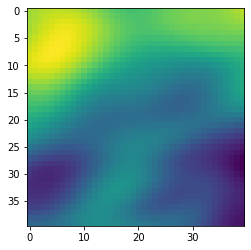

In [8]:
a = dg_train.__getitem__(8)[0]
plt.imshow(a[0,11,:,:,0])
plt.show()

In [9]:
result = model(np.expand_dims(a[0], axis=0)).numpy()

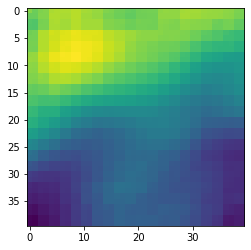

In [10]:
plt.imshow((result[0,11,:,:,0]))
plt.show()

In [11]:
test_data = z_train.sel(time=slice('1979-05-01T16:00:00','1979-05-02T03:00:00' ),level = slice(1),longitude=slice(6,15.75), latitude=slice(55.5,45.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
# Normalize
mean = test_data['t'].mean(('time', 'latitude', 'longitude')).compute()
std = test_data['t'].std('time').mean(('latitude', 'longitude')).compute() 
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 12, 40, 40, 1)

## Results

Original:

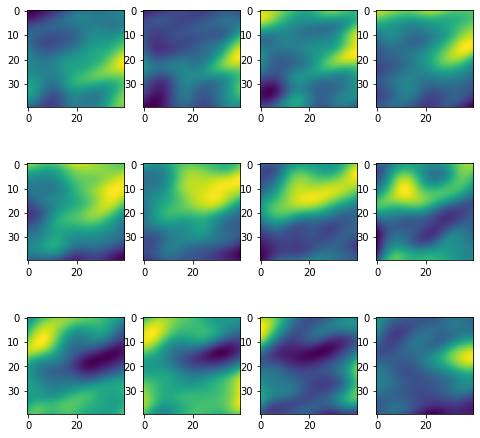

In [12]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(0, columns*rows):
    img = test_data[0,i,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

Decompressed:

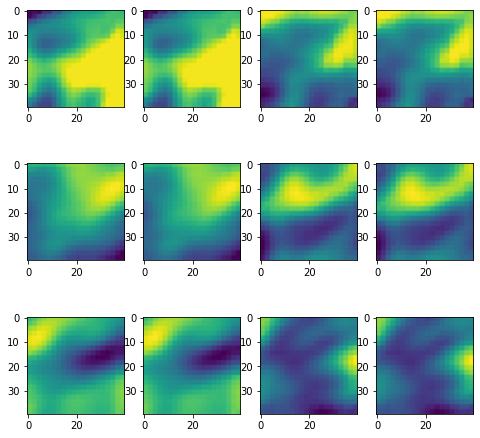

In [13]:
result2 = model(test_data).numpy()
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(0, columns*rows):
    img = result2[0,i,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

The checkerboard dissapeared, however, the model is not learning that good anymore. We let it run for 300 epochs. But why? Maybe we should check the Tensorboard to see how the gradients are behaving.

Ok, just checked the kernel weights distribution and everything seems fine...